#  Imports & Environment Setup
Import all required libraries and configure global settings for a clean and reproducible workflow.

In [1]:
#  Imports & Setup 
import os, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


#  Data Loading
Load the main dataset, verify its shape, and inspect column names.

In [2]:
#  Load CSV 
CSV_PATH = "ad_intelligence.csv"  

df = pd.read_csv(CSV_PATH)
print(f"Loaded: {CSV_PATH}  |  Shape: {df.shape}")
print("Columns:", list(df.columns))
df.head(10)

Loaded: ad_intelligence.csv  |  Shape: (10000, 12)
Columns: ['ID', 'business_type', 'campaign_goal', 'budget_level', 'campaign_duration', 'area_type', 'active_hours', 'ad_style', 'interaction_goal', 'offer_type', 'business_stage', 'best_place']


,ID,business_type,campaign_goal,budget_level,campaign_duration,area_type,active_hours,ad_style,interaction_goal,offer_type,business_stage,best_place
0,1,clinic,sales,low,short_week,main_street,evening,coupon_offer,store_visit,product,new,malls
1,2,electronics,sales,low,mid_month,main_street,morning,static_image,purchase,product,famous,malls
2,3,fashion_store,sales,high,short_week,inside_mall,morning,coupon_offer,purchase,service,established,malls
3,4,education_center,sales,medium,long_2months,main_street,evening,static_image,purchase,product,new,streets
4,5,restaurant,sales,low,short_week,main_street,noon,short_video,store_visit,product,famous,malls
5,6,clinic,sales,medium,short_week,inside_mall,evening,static_image,website_visit,service,famous,malls
6,7,restaurant,sales,low,short_week,near_entertainment,evening,short_video,purchase,product,famous,malls
7,8,cafe,sales,medium,short_week,main_street,evening,short_video,store_visit,experience,established,entertainment_restaurants
8,9,restaurant,sales,medium,mid_month,main_street,morning,short_video,social_follow,product,famous,entertainment_restaurants
9,10,restaurant,awareness,medium,mid_month,inside_mall,evening,short_video,website_visit,product,famous,entertainment_restaurants


## Exploratory Data Analysis (EDA)

This step provides a quick visual overview of the dataset to understand feature distributions, relationships, and any basic patterns before building the prediction model.

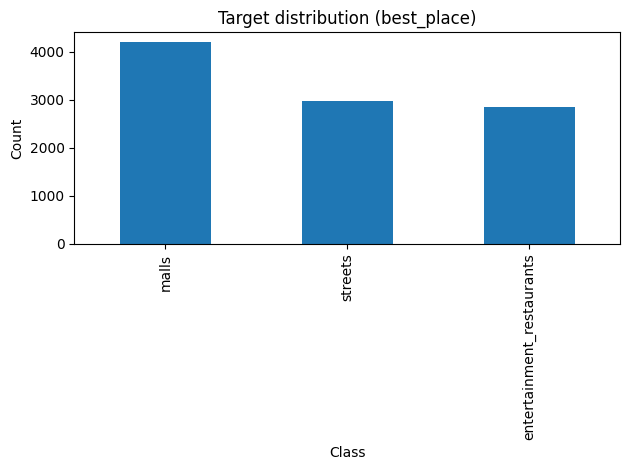

Missing ratio (top 20):
ID                   0.0
business_type        0.0
campaign_goal        0.0
budget_level         0.0
campaign_duration    0.0
area_type            0.0
active_hours         0.0
ad_style             0.0
interaction_goal     0.0
offer_type           0.0
business_stage       0.0
best_place           0.0
dtype: float64


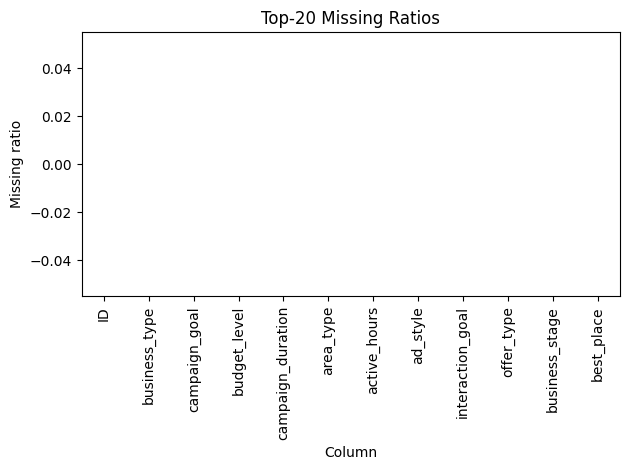

In [3]:
#  EDA (Target distribution + Missingness) 
# Target distribution
ax = df["best_place"].value_counts().plot(kind="bar")
ax.set_title("Target distribution (best_place)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Missingness
missing = df.isna().mean().sort_values(ascending=False)
print("Missing ratio (top 20):")
print(missing.head(20))

ax = missing.head(20).plot(kind="bar")
ax.set_title("Top-20 Missing Ratios")
ax.set_xlabel("Column")
ax.set_ylabel("Missing ratio")
plt.tight_layout()
plt.show()

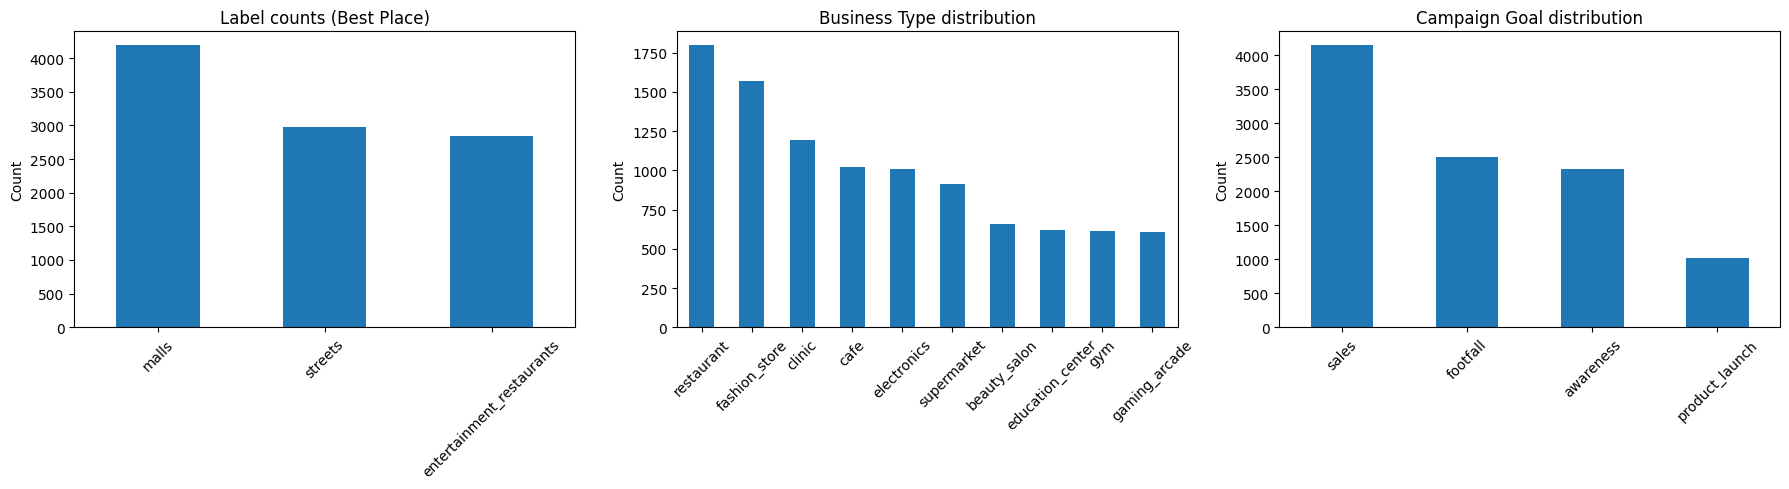

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# Cell 3A – Global distributions (label + key categorical features)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cols   = ["best_place", "business_type", "campaign_goal"]
titles = [
    "Label counts (Best Place)",
    "Business Type distribution",
    "Campaign Goal distribution"
]

for ax, col, title in zip(axes, cols, titles):
    df[col].value_counts().plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

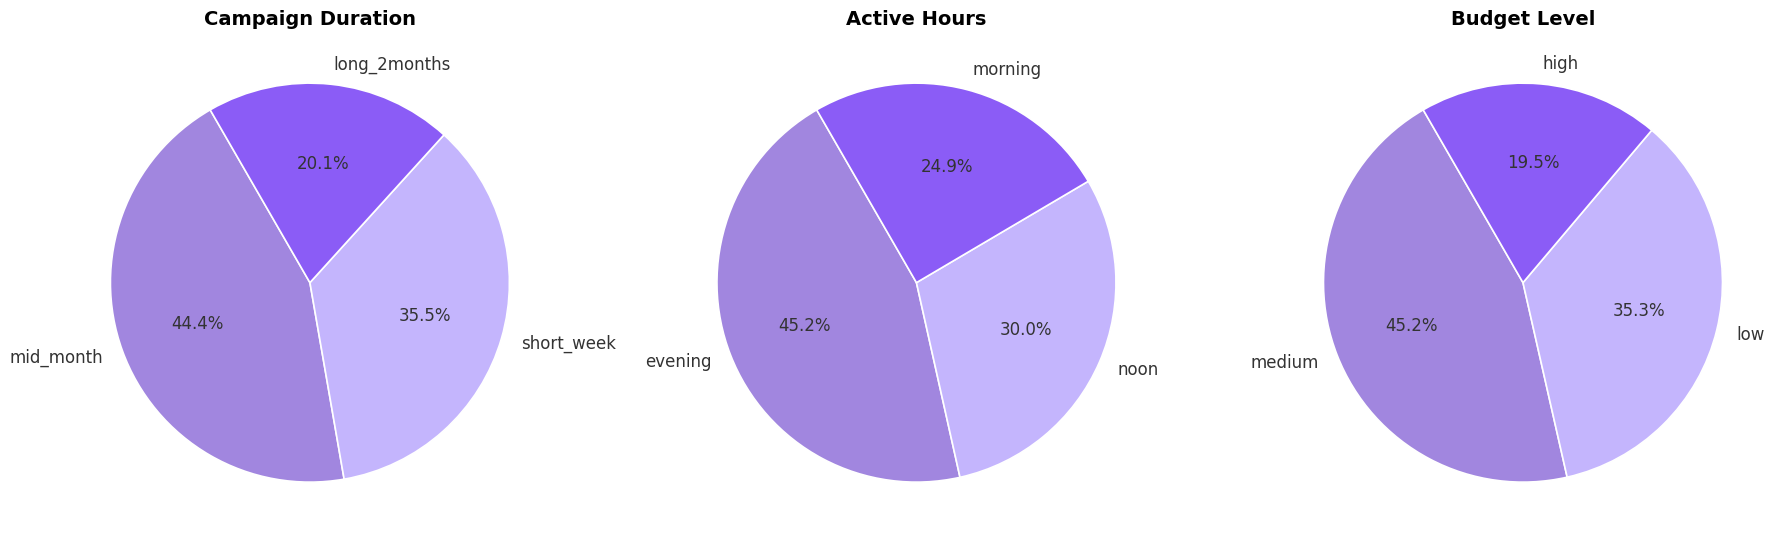

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cols   = ["campaign_duration", "active_hours", "budget_level"]
titles = ["Campaign Duration", "Active Hours", "Budget Level"]

colors = [
    "#A186DF",  
    "#C4B5FD",  
    "#8B5CF6",  
    "#EC4899",  
    "#3B82F6",  
    "#F59E0B",  
]

for ax, col, title in zip(axes, cols, titles):
    counts = df[col].value_counts()
    ax.pie(
        counts,
        labels=counts.index,
        autopct="%1.1f%%",
        startangle=120,
        colors=colors[:len(counts)],
        textprops={"color": "#333", "fontsize": 12},
        wedgeprops={"edgecolor": "white", "linewidth": 1.2}
    )
    ax.set_title(title, fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

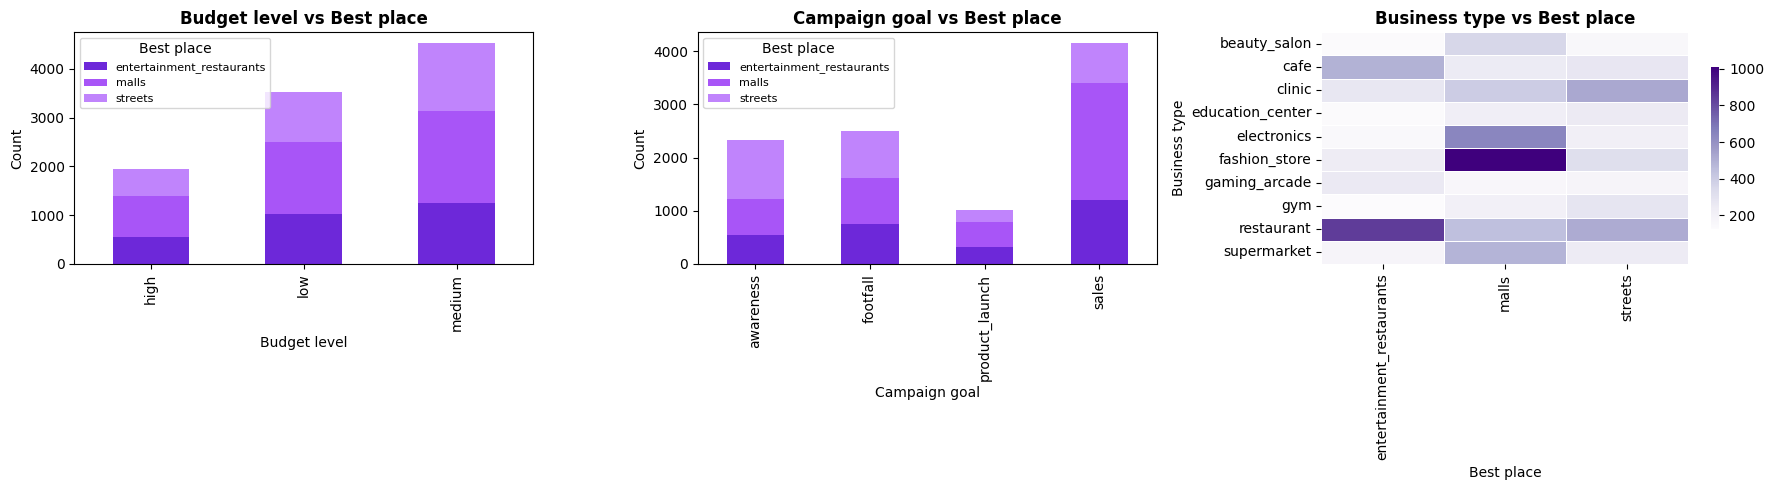

In [6]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

palette_stack = [
    "#6D28D9", 
    "#A855F7",  
    "#C084FC",  
    "#EC4899",  
    "#F472B6",  
    "#38BDF8",  
    "#0EA5E9",  
]

ct1 = pd.crosstab(df["budget_level"], df["best_place"])
ct1.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=palette_stack[:len(ct1.columns)]
)
axes[0].set_title("Budget level vs Best place", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Budget level")
axes[0].legend(title="Best place", fontsize=8)

ct2 = pd.crosstab(df["campaign_goal"], df["best_place"])
ct2.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    color=palette_stack[:len(ct2.columns)]
)
axes[1].set_title("Campaign goal vs Best place", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Campaign goal")
axes[1].legend(title="Best place", fontsize=8)

ct3 = pd.crosstab(df["business_type"], df["best_place"])

sns.heatmap(
    ct3,
    cmap="Purples",     
    linewidths=0.5,
    linecolor="white",
    ax=axes[2],
    cbar_kws={"shrink": 0.7}
)

axes[2].set_title("Business type vs Best place", fontsize=12, fontweight="bold")
axes[2].set_xlabel("Best place")
axes[2].set_ylabel("Business type")

plt.tight_layout()
plt.show()

# Feature Selection

This step selects the input features, removes non-useful columns, and separates categorical and numerical variables.

In [7]:
#  Feature Selection 
TARGET = "best_place"
DROP_COLS = {"ID"}  

feature_cols = [c for c in df.columns if c != TARGET and c not in DROP_COLS]
X = df[feature_cols].copy()
y = df[TARGET].astype(str).copy()

# Identify dtypes
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"Total features: {len(feature_cols)}")
print(f"Categorical: {len(cat_cols)} | Numeric: {len(num_cols)}")
print("Sample categorical:", cat_cols[:10])
print("Sample numeric:", num_cols[:10])

Total features: 10
Categorical: 10 | Numeric: 0
Sample categorical: ['business_type', 'campaign_goal', 'budget_level', 'campaign_duration', 'area_type', 'active_hours', 'ad_style', 'interaction_goal', 'offer_type', 'business_stage']
Sample numeric: []


# Data Preprocessing & Train/Test Split

This step handles missing values, encodes categorical features, scales numeric fields, and splits the dataset into training and testing sets for model evaluation.

In [8]:
#  Preprocess & Split 
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_cols),
        ("num", numeric_transformer, num_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train/Test shapes -> {X_train.shape} / {X_test.shape}")

Train/Test shapes -> (8000, 10) / (2000, 10)


#  XGBoost Availability Check

In [9]:
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

#  Model Training & Comparison
Train multiple machine learning models and compare their performance on test data.

In [10]:
# Train & Evaluate Multiple Models  
from sklearn.preprocessing import LabelEncoder

models = {}

# Model 1: Multinomial Logistic Regression
models["logreg"] = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        class_weight="balanced",
        max_iter=4000,
        C=2.0,
      
    ))
])

# Model 2: Random Forest
models["rf"] = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=700,
        max_depth=22,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])

# Model 3: XGBoost 
if XGB_AVAILABLE:
    models["xgb"] = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", XGBClassifier(
            objective="multi:softprob",
            learning_rate=0.08,
            n_estimators=600,
            max_depth=7,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_lambda=1.2,
            reg_alpha=0.0,
            tree_method="hist",
            random_state=42,
            eval_metric="mlogloss"
        ))
    ])

results = {}
labels_sorted = sorted(y.unique())

# Label encoder only for XGBoost
le = LabelEncoder().fit(y) if XGB_AVAILABLE and "xgb" in models else None

for name, pipe in models.items():
    if name == "xgb":
        # Encode y for XGBoost
        y_train_enc = le.transform(y_train)
        y_test_enc  = le.transform(y_test)

        pipe.fit(X_train, y_train_enc)
        y_pred_enc = pipe.predict(X_test)
        # Decode predictions back to string labels for reporting
        y_pred = le.inverse_transform(y_pred_enc)
        y_true = y_test  # keep original string labels for reports
    else:
        # Normal flow for sklearn models (string labels are OK)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_true = y_test

    acc = accuracy_score(y_true, y_pred)
    cr  = classification_report(y_true, y_pred, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    results[name] = {"acc": acc, "cr": cr, "cm": cm}

    print("\n" + "="*60)
    print(f"{name.upper()} | Accuracy: {acc:.4f}")
    print("-"*60)
    print(cr)

c:\Users\hlaa7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LOGREG | Accuracy: 0.7435
------------------------------------------------------------
                           precision    recall  f1-score   support

entertainment_restaurants       0.71      0.76      0.74       567
                    malls       0.82      0.71      0.76       838
                  streets       0.69      0.77      0.73       595

                 accuracy                           0.74      2000
                macro avg       0.74      0.75      0.74      2000
             weighted avg       0.75      0.74      0.74      2000


RF | Accuracy: 0.8570
------------------------------------------------------------
                           precision    recall  f1-score   support

entertainment_restaurants       0.82      0.82      0.82       567
                    malls       0.89      0.88      0.89       838
                  streets       0.85      0.86      0.85       595

                 accuracy                           0.86      2000
                mac

#  Confusion Matrix (Best Model)
Visualize how the best model performs across all categories.

BEST MODEL: RF (Accuracy=0.8570)


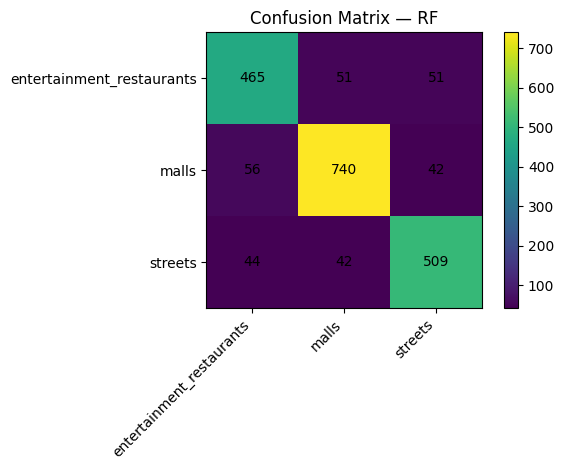

In [11]:
#  Best Model + Confusion Matrix Plot 
best_name = max(results, key=lambda k: results[k]["acc"])
best_acc = results[best_name]["acc"]
best_pipe = models[best_name]
labels_sorted = sorted(y.unique())
cm = results[best_name]["cm"]

print(f"BEST MODEL: {best_name.upper()} (Accuracy={best_acc:.4f})")

plt.imshow(cm, interpolation="nearest")
plt.colorbar()
plt.title(f"Confusion Matrix — {best_name.upper()}")
plt.xticks(ticks=np.arange(len(labels_sorted)), labels=labels_sorted, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(labels_sorted)), labels=labels_sorted)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

#  Cross-Validation & Generalization Check
Evaluate model robustness using 5-fold cross-validation and analyze potential overfitting.

In [12]:
#  Cross-Validation with Accuracy + Macro-F1 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np


rf_cv = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=600,
        max_depth=16,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    ))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, f1s = [], []
for tr, va in skf.split(X, y):
    Xtr, Xva = X.iloc[tr], X.iloc[va]
    ytr, yva = y.iloc[tr], y.iloc[va]

    rf_cv.fit(Xtr, ytr)
    pred = rf_cv.predict(Xva)

    accs.append(accuracy_score(yva, pred))
    f1s.append(f1_score(yva, pred, average="macro", zero_division=0))

acc_mean, acc_std = np.mean(accs), np.std(accs)
f1_mean,  f1_std  = np.mean(f1s),  np.std(f1s)

print(f"[5-Fold CV] Accuracy: {acc_mean*100:.2f}% ±{acc_std*100:.2f}%")
print(f"[5-Fold CV] Macro-F1: {f1_mean*100:.2f}% ±{f1_std*100:.2f}%")

[5-Fold CV] Accuracy: 85.22% ±0.41%
[5-Fold CV] Macro-F1: 84.76% ±0.37%


Train Accuracy: 92.21%
Test  Accuracy: 85.70%
Gap (Train - Test): 6.51 pp


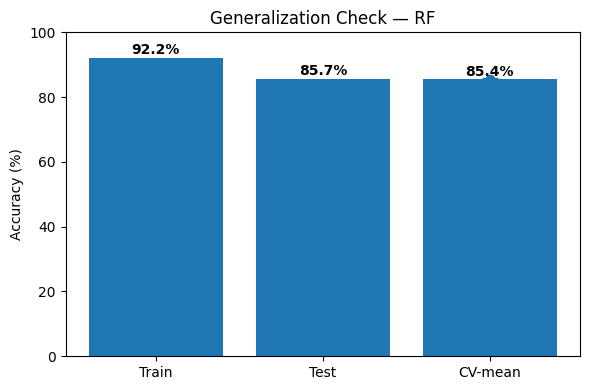

 Mild overfitting: train-test gap between 5–10pp.


In [13]:
#  Overfitting + 5-Fold Cross-Validation (clean) 
from copy import deepcopy
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, f1_score
import numpy as np
import matplotlib.pyplot as plt

def _predict_strings(pipe, X_, model_name, label_encoder=None):
    """Return string labels regardless of internal encoding for plotting/metrics."""
    yhat = pipe.predict(X_)
    if model_name == "xgb" and label_encoder is not None:
        yhat = label_encoder.inverse_transform(yhat)
    return yhat

# 1) Train/Test metrics (percent)
yhat_train = _predict_strings(best_pipe, X_train, best_name, le if 'le' in globals() else None)
yhat_test  = _predict_strings(best_pipe, X_test,  best_name, le if 'le' in globals() else None)

train_acc = accuracy_score(y_train, yhat_train) * 100.0
test_acc  = accuracy_score(y_test,  yhat_test)  * 100.0
gap_pp    = train_acc - test_acc  # percentage points

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test  Accuracy: {test_acc:.2f}%")
print(f"Gap (Train - Test): {gap_pp:.2f} pp")

# 2) 5-fold CV on the SAME model type
#    - Clone the chosen pipeline to avoid data leakage from fitted encoders
cv_pipe = deepcopy(models[best_name])

# For XGBoost, ensure y is numeric during CV
if best_name == "xgb":
    if 'le' not in globals() or le is None:
        from sklearn.preprocessing import LabelEncoder
        le_cv = LabelEncoder().fit(y)
    else:
        le_cv = le
    y_cv = le_cv.transform(y)
else:
    le_cv = None
    y_cv = y

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Primary metric: Accuracy
cv_acc = cross_val_score(cv_pipe, X, y_cv, cv=cv, scoring="accuracy", n_jobs=-1)
cv_acc_mean = float(np.mean(cv_acc) * 100.0)
cv_acc_std  = float(np.std(cv_acc)  * 100.0)

# Secondary metric: Macro-F1 
f1_macro = make_scorer(f1_score, average="macro")
cv_f1 = cross_val_score(cv_pipe, X, y_cv, cv=cv, scoring=f1_macro, n_jobs=-1)
cv_f1_mean = float(np.mean(cv_f1) * 100.0)
cv_f1_std  = float(np.std(cv_f1)  * 100.0)



# 3) Visualization: Train vs Test vs CV (mean ± std)
bars = ["Train", "Test", "CV-mean"]
vals = [train_acc, test_acc, cv_acc_mean]

plt.figure(figsize=(6,4))
plt.bar(bars, vals)
plt.errorbar([2], [cv_acc_mean], yerr=[cv_acc_std], fmt='o', capsize=6)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Generalization Check — {best_name.upper()}")
for i, v in enumerate(vals):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center", fontweight="bold")
plt.tight_layout()
plt.show()

# 4) Interpretation (simple, research-informed thresholds)
#    Common practical thresholds:
#    - gap > 10 percentage points with high train acc => likely overfitting
#    - 8 < gap ≤ 10 => mild overfitting
#    - Test acc << CV mean - 1*std => potential distribution shift / data leakage suspicion
notes = []
if gap_pp > 10 and train_acc > 90:
    notes.append("Likely overfitting: very high train vs much lower test (gap > 10pp).")
elif gap_pp > 5:
    notes.append(" Mild overfitting: train-test gap between 5–10pp.")
else:
    notes.append(" No material train-test gap observed (≤ 8pp).")

if test_acc < (cv_acc_mean - cv_acc_std):
    notes.append(" Test < (CV mean − 1σ): possible shift between train/test split and overall data.")
elif test_acc > (cv_acc_mean + cv_acc_std):
    notes.append("ℹ Test > (CV mean + 1σ): test split may be slightly easier than average folds.")

print("\n".join(notes))

#  Save Final Model
Export the fully trained pipeline for deployment in backend prediction.

In [14]:
# Here we choose Random Forest as our final production model,
# and save its full pipeline (preprocessing + RF) for later use.
import joblib

model_path = "best_place_model.pkl"
joblib.dump(models["rf"], model_path)

print(f" Model saved successfully as '{model_path}'")

 Model saved successfully as 'best_place_model.pkl'
